In [1]:
!pip -q install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

Датасет

In [3]:
df = pd.read_csv('dataset_CC50_median.csv')

Целевой столбец High_CC50

In [5]:
target_col = 'High_CC50'
X = df.drop(columns=[target_col])
y = df[target_col]

Разделяем выборки

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Масштабируем признаки

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

PCA

In [8]:
pca = PCA(n_components=15, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Подбор гиперпараметров

In [9]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

param_grids = {
    'LogisticRegression': {
        'C': np.logspace(-3, 2, 6),
        'penalty': ['l2']
    },
    'DecisionTree': {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'RandomForest': {
        'n_estimators': [100, 300],
        'max_depth': [10, 20, None],
        'min_samples_leaf': [1, 2]
    },
    'CatBoost': {
        'depth': [4, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'l2_leaf_reg': [1, 3, 5]
    }
}

Обучение моделей

In [10]:
best_models = {}

for name, model in models.items():
    print(f"Тюнинг: {name}")
    param_grid = param_grids[name]

    search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=10,
        cv=3,
        scoring='f1',
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train_pca, y_train)
    best_models[name] = search.best_estimator_

Тюнинг: LogisticRegression


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Тюнинг: DecisionTree
Тюнинг: RandomForest
Тюнинг: CatBoost


Оцениваем метрики: Accuracy, Precision, Recall и F1-score

In [11]:
results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test_pca)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1
    })

In [12]:
results_df = pd.DataFrame(results).sort_values('F1-score', ascending=False).reset_index(drop=True)
print("\nИтоговая таблица результатов:\n")
print(results_df.to_string(index=False))


Итоговая таблица результатов:

             Model  Accuracy  Precision  Recall  F1-score
      RandomForest  0.761194   0.740741    0.80  0.769231
          CatBoost  0.736318   0.711712    0.79  0.748815
      DecisionTree  0.711443   0.698113    0.74  0.718447
LogisticRegression  0.661692   0.660000    0.66  0.660000


Гистограммы

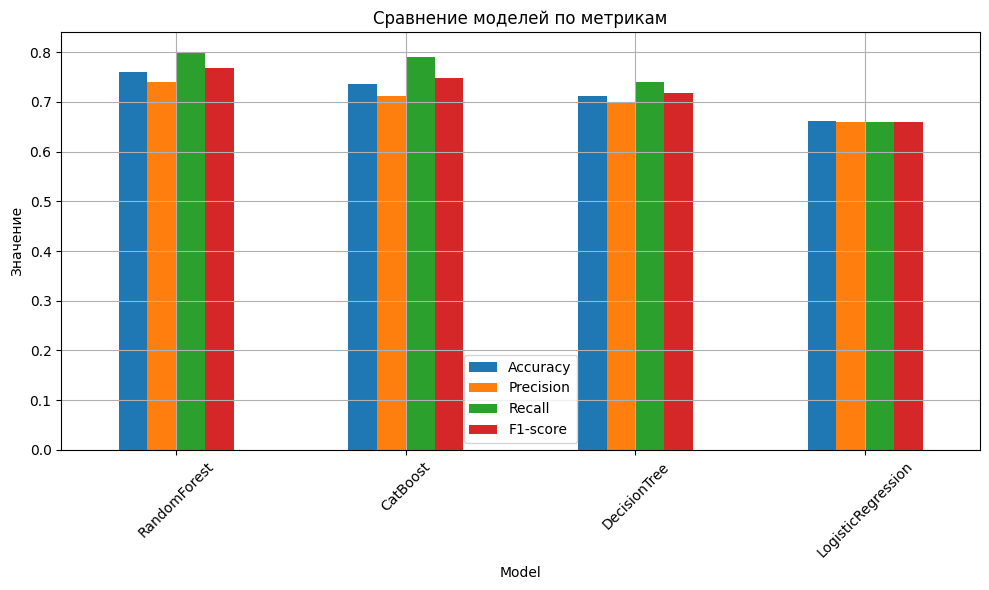

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-score']].plot(kind='bar', ax=ax)

plt.title("Сравнение моделей по метрикам")
plt.ylabel("Значение")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Здесь также все модели справились довольно хорошо, лучше всех поазал результаты Случайный Лес.